In [1]:
using GraphMakie
using CSV
using DataFrames
using DelimitedFiles
using ColorSchemes
using Plots
using PlotThemes
using SankeyPlots

theme(:ggplot2)

In [2]:
Tree = Matrix(DataFrame(CSV.File("data/tree_matrix.csv")))



5509×5510 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0 

In [3]:
complex_names = vec(readdlm("data/complex_ids.txt", '\t', String, '\n'))
monomer_names = vec(readdlm("data/protein_ids.txt", '\t', String, '\n'))
cofactor_names = vec(readdlm("data/cofactor_ids.txt", '\t', String, '\n'))
element_names = vec(readdlm("data/element_ids.txt", '\t', String, '\n'))
pathway_names = vec(readdlm("data/pathway_ids.txt", '\t', String, '\n'))

protein_names = [complex_names; monomer_names]

C = Matrix(DataFrame(CSV.File("data/C_matrix.csv", header=false)))
P = Matrix(DataFrame(CSV.File("data/P_matrix.csv", header=false)))
E = Matrix(DataFrame(CSV.File("data/E_matrix.csv", header=false)))
W = Matrix(DataFrame(CSV.File("data/W_matrix.csv", header=false)))
W2 = Matrix(DataFrame(CSV.File("data/W2_matrix.csv", header=false)))
W1 = Matrix(DataFrame(CSV.File("data/W1_matrix.csv", header=false)))

counts = vec(Matrix(DataFrame(CSV.File("data/counts.csv", header=false))))


5488-element Vector{Int64}:
   31
   86
 1049
 2617
  171
  485
  523
   59
 2036
   98
   47
  111
   18
    ⋮
    0
    1
    0
    1
  115
    9
   34
    0
    0
  522
    0
   39

In [4]:
Counts = repeat(counts, 1, length(monomer_names))

C_counts = C .* Counts

C_counts_elements = C_counts * P * E

5488×19 Matrix{Int64}:
 0  0  0  0  0    0    0     0     0  …     0      0  0      0  0  0    0  0
 0  0  0  0  0  344    0     0  2580     4644      0  0      0  0  0    0  0
 0  0  0  0  0    0    0  2098     0        0      0  0      0  0  0    0  0
 0  0  0  0  0    0    0     0     0        0  10468  0  10468  0  0    0  0
 0  0  0  0  0    0    0  1710     0        0      0  0      0  0  0    0  0
 0  0  0  0  0    0    0     0     0  …     0      0  0      0  0  0    0  0
 0  0  0  0  0    0    0  2092     0        0      0  0      0  0  0    0  0
 0  0  0  0  0    0  118   118     0        0      0  0      0  0  0    0  0
 0  0  0  0  0    0    0     0     0        0      0  0      0  0  0    0  0
 0  0  0  0  0    0    0     0     0        0      0  0      0  0  0    0  0
 0  0  0  0  0   94    0     0   564  …   752      0  0      0  0  0    0  0
 0  0  0  0  0    0    0     0     0        0      0  0      0  0  0    0  0
 0  0  0  0  0    0    0     0     0        0      0 

# Create Sankey diagram of where the iron flows in the cell.

In [5]:
element_names

19-element Vector{String}:
 "CA"
 "MN"
 "CU"
 "SE"
 "R"
 "P"
 "K"
 "MG"
 "O"
 "H"
 "N"
 "C"
 "S"
 "NA"
 "FE"
 "CO"
 "NI"
 "ZN"
 "MO"

# Redoing the plotting prep 

In [6]:
cur_elements = ["ZN"]
cap_entries = 30

# create counts matrices
C_P_counts = C .* repeat(counts, 1, length(monomer_names))
C_E_counts = C_P_counts * P * E


C_norm = Array{Float64}(copy(C))

for i in 1:size(C)[2]
    C_norm[i, :] = C[i, :] / sum(C[i, :])
end

C_P_norm_counts = C_norm .* repeat(counts, 1, length(monomer_names))
C_W_norm_counts_cats = C_P_norm_counts * W * W2

# creating indices of interest
element_idxs = [element in cur_elements for element in element_names]

## cplx sorted by counts of elements
capped_complex_idx = sortperm(vec(sum(C_E_counts[:, element_idxs], dims=2)), rev=true)[1:cap_entries]
capped_classes = findall(vec(sum(C_W_norm_counts_cats[capped_complex_idx, :],dims=1) .!= 0))

capped_C_E = C_E_counts[capped_complex_idx, element_idxs]
capped_C_W = C_W_norm_counts_cats[capped_complex_idx, capped_classes]

n_cplx = length(capped_complex_idx)
n_classes = length(capped_classes)
n_elements = length(cur_elements)

# initialize arrays
src = Vector{Int64}()
dst = Vector{Int64}()
weights = Vector{Int64}()

# create labels
node_labels = [element_names[element_idxs]; 
                protein_names[capped_complex_idx]; 
                pathway_names[capped_classes]]

# create colors
colors = zeros(Int64, length(node_labels))

element_colors = collect(1:(n_elements))
other_color = 0

colors[1:n_elements] = element_colors

# create sorting
## sorts elements
ordering_elements = Vector{Pair{Int64, Int64}}()
sort_elements = sortperm(vec(sum(capped_C_E, dims=1)), rev=true)
for i in 1:(n_elements-1)
    push!(ordering_elements, sort_elements[i]=>sort_elements[i+1])
end

## sorts cplxes
# for j in 1:n_elements
#     sort_cplxs = sortperm(vec(sum(capped_C_E[:, j], dims=2)), rev=true)
#     nz_count = sum(capped_C_E[:, j] .!= 0)
    
#     for i in 1:(nz_count-1)
#         push!(ordering_elements, n_elements+sort_cplxs[i]=>n_elements+sort_cplxs[i+1]) 
#     end
# end

# sort_cplxs = sortperm(vec(sum(capped_C_E, dims=2)), rev=true)
# for i in 1:(n_cplx-1)
#     push!(ordering_elements, n_elements+sort_cplxs[i]=>n_elements+sort_cplxs[i+1]) 
# end

# chart progress: E -> C -> W
# E -> C, reverse order because im a dumbass
for i in 1:n_elements
    for j in 1:n_cplx
        if capped_C_E[j, i] != 0
            
            push!(src, i)
            push!(dst, n_elements + j)
            push!(weights, capped_C_E[j, i])
            
            colors[n_elements + j] = colors[i]
            
        end  
    end
end

# push!(src, n_elements + 1)
# push!(dst, n_elements + n_cplx + 1)
# push!(weights, 10000)   

# # C -> W
for i in 1:n_cplx
    for j in 1:n_classes
        if capped_C_W[i, j] != 0
            
            # multiply by sum of counts for classes
            cur_idx = capped_complex_idx[i]
            corrective_factor = sum((C * P * E)[cur_idx, element_idxs])
            
            push!(src, n_elements + i)
            push!(dst, n_elements + n_cplx + j)
            push!(weights, trunc(Int64, capped_C_W[i, j] * corrective_factor))   
            
            colors[n_elements + n_cplx + j] = colors[n_elements + i]
            
        end  
    end
end


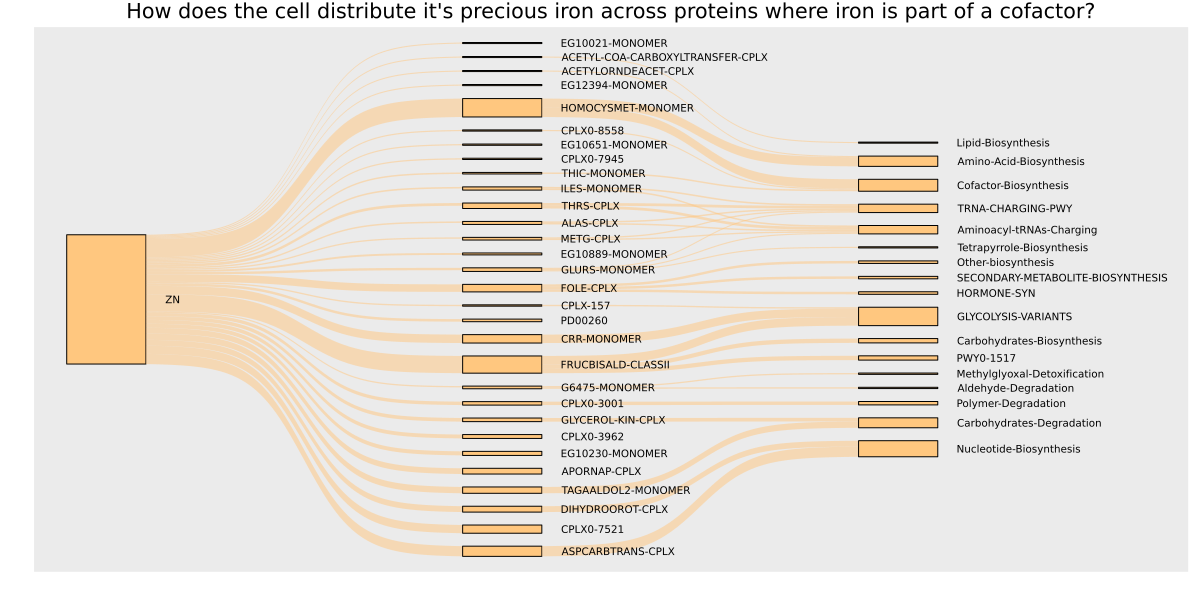

In [7]:
sankey(src, dst, weights, 
        compact = true,
        node_labels = node_labels,
        node_colors = cgrad(:copper, maximum(colors)+1, categorical = true, rev=true)[colors],
        edge_color = :src,
        size=(1200, 600),
        label_position = :right,
        label_size = 7,
        force_order = ordering_elements,
        title="How does the cell distribute it's precious iron across proteins where iron is part of a cofactor?"
)

# savefig("iron_cofactor_plot_biggg.png")

# Rare elements

In [17]:
cur_elements = ["MN"]
cap_entries = 8

# create counts matrices
C_P_counts = C .* repeat(counts, 1, length(monomer_names))
C_E_counts = C_P_counts * P * E


C_norm = Array{Float64}(copy(C))

for i in 1:size(C)[2]
    C_norm[i, :] = C[i, :] / sum(C[i, :])
end

C_P_norm_counts = C_norm .* repeat(counts, 1, length(monomer_names))
C_W_norm_counts_cats = C_P_norm_counts * W * W2

# creating indices of interest
element_idxs = [element in cur_elements for element in element_names]

## cplx sorted by counts of elements
capped_complex_idx = sortperm(vec(sum(C_E_counts[:, element_idxs], dims=2)), rev=true)[1:cap_entries]
capped_classes = findall(vec(sum(C_W_norm_counts_cats[capped_complex_idx, :],dims=1) .!= 0))

capped_C_E = C_E_counts[capped_complex_idx, element_idxs]
capped_C_W = C_W_norm_counts_cats[capped_complex_idx, capped_classes]

n_cplx = length(capped_complex_idx)
n_classes = length(capped_classes)
n_elements = length(cur_elements)

# initialize arrays
src = Vector{Int64}()
dst = Vector{Int64}()
weights = Vector{Int64}()

# create labels
node_labels = [element_names[element_idxs]; 
                protein_names[capped_complex_idx]; 
                pathway_names[capped_classes]]

# create colors
colors = zeros(Int64, length(node_labels))

element_colors = collect(1:(n_elements))
other_color = 0

colors[1:n_elements] = element_colors

# create sorting
## sorts elements
ordering_elements = Vector{Pair{Int64, Int64}}()
sort_elements = sortperm(vec(sum(capped_C_E, dims=1)), rev=true)
for i in 1:(n_elements-1)
    push!(ordering_elements, sort_elements[i]=>sort_elements[i+1])
end

## sorts cplxes
# for j in 1:n_elements
#     sort_cplxs = sortperm(vec(sum(capped_C_E[:, j], dims=2)), rev=true)
#     nz_count = sum(capped_C_E[:, j] .!= 0)
    
#     for i in 1:(nz_count-1)
#         push!(ordering_elements, n_elements+sort_cplxs[i]=>n_elements+sort_cplxs[i+1]) 
#     end
# end

# sort_cplxs = sortperm(vec(sum(capped_C_E, dims=2)), rev=true)
# for i in 1:(n_cplx-1)
#     push!(ordering_elements, n_elements+sort_cplxs[i]=>n_elements+sort_cplxs[i+1]) 
# end

# chart progress: E -> C -> W
# E -> C, reverse order because im a dumbass
for i in 1:n_elements
    for j in 1:n_cplx
        if capped_C_E[j, i] != 0
            
            push!(src, i)
            push!(dst, n_elements + j)
            push!(weights, capped_C_E[j, i])
            
            colors[n_elements + j] = colors[i]
            
        end  
    end
end

# push!(src, n_elements + 1)
# push!(dst, n_elements + n_cplx + 1)
# push!(weights, 10000)   

# # C -> W
for i in 1:n_cplx
    for j in 1:n_classes
        if capped_C_W[i, j] != 0
            
            # multiply by sum of counts for classes
            cur_idx = capped_complex_idx[i]
            corrective_factor = sum((C * P * E)[cur_idx, element_idxs])
            
            push!(src, n_elements + i)
            push!(dst, n_elements + n_cplx + j)
            push!(weights, trunc(Int64, capped_C_W[i, j] * corrective_factor))   
            
            colors[n_elements + n_cplx + j] = colors[n_elements + i]
            
        end  
    end
end


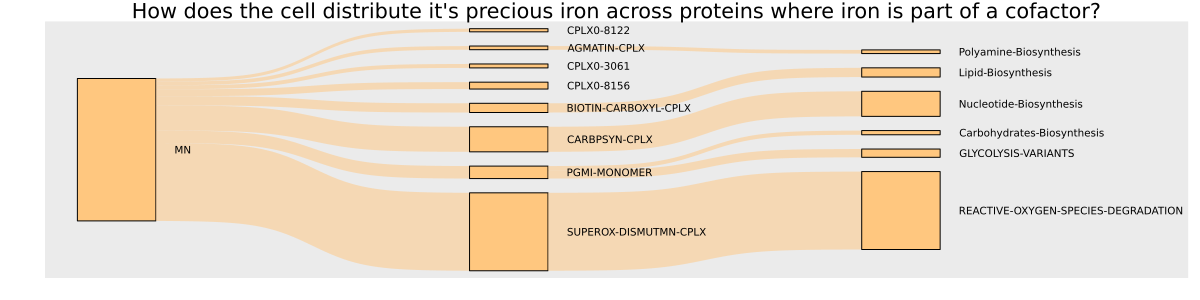

In [20]:
sankey(src, dst, weights, 
        compact = true,
        node_labels = node_labels,
        node_colors = cgrad(:copper, maximum(colors)+1, categorical = true, rev=true)[colors],
        edge_color = :src,
        size=(1200, 300),
        label_position = :right,
        label_size = 7,
        force_order = ordering_elements,
        title="How does the cell distribute it's precious iron across proteins where iron is part of a cofactor?"
)

# savefig("iron_cofactor_plot_biggg.png")

# rare elements

In [23]:
cur_elements = ["CA", "CU", "MO"]
cap_entries = 12

# create counts matrices
C_P_counts = C .* repeat(counts, 1, length(monomer_names))
C_E_counts = C_P_counts * P * E


C_norm = Array{Float64}(copy(C))

for i in 1:size(C)[2]
    C_norm[i, :] = C[i, :] / sum(C[i, :])
end

C_P_norm_counts = C_norm .* repeat(counts, 1, length(monomer_names))
C_W_norm_counts_cats = C_P_norm_counts * W * W2

# creating indices of interest
element_idxs = [element in cur_elements for element in element_names]

## cplx sorted by counts of elements
capped_complex_idx = sortperm(vec(sum(C_E_counts[:, element_idxs], dims=2)), rev=true)[1:cap_entries]
capped_classes = findall(vec(sum(C_W_norm_counts_cats[capped_complex_idx, :],dims=1) .!= 0))

capped_C_E = C_E_counts[capped_complex_idx, element_idxs]
capped_C_W = C_W_norm_counts_cats[capped_complex_idx, capped_classes]

n_cplx = length(capped_complex_idx)
n_classes = length(capped_classes)
n_elements = length(cur_elements)

# initialize arrays
src = Vector{Int64}()
dst = Vector{Int64}()
weights = Vector{Int64}()

# create labels
node_labels = [element_names[element_idxs]; 
                protein_names[capped_complex_idx]; 
                pathway_names[capped_classes]]

# create colors
colors = zeros(Int64, length(node_labels))

element_colors = collect(1:(n_elements))
other_color = 0

colors[1:n_elements] = element_colors

# create sorting
## sorts elements
ordering_elements = Vector{Pair{Int64, Int64}}()
sort_elements = sortperm(vec(sum(capped_C_E, dims=1)), rev=true)
for i in 1:(n_elements-1)
    push!(ordering_elements, sort_elements[i]=>sort_elements[i+1])
end

## sorts cplxes
# for j in 1:n_elements
#     sort_cplxs = sortperm(vec(sum(capped_C_E[:, j], dims=2)), rev=true)
#     nz_count = sum(capped_C_E[:, j] .!= 0)
    
#     for i in 1:(nz_count-1)
#         push!(ordering_elements, n_elements+sort_cplxs[i]=>n_elements+sort_cplxs[i+1]) 
#     end
# end

# sort_cplxs = sortperm(vec(sum(capped_C_E, dims=2)), rev=true)
# for i in 1:(n_cplx-1)
#     push!(ordering_elements, n_elements+sort_cplxs[i]=>n_elements+sort_cplxs[i+1]) 
# end

# chart progress: E -> C -> W
# E -> C, reverse order because im a dumbass
for i in 1:n_elements
    for j in 1:n_cplx
        if capped_C_E[j, i] != 0
            
            push!(src, i)
            push!(dst, n_elements + j)
            push!(weights, capped_C_E[j, i])
            
            colors[n_elements + j] = colors[i]
            
        end  
    end
end

# push!(src, n_elements + 1)
# push!(dst, n_elements + n_cplx + 1)
# push!(weights, 10000)   

# # C -> W
for i in 1:n_cplx
    for j in 1:n_classes
        if capped_C_W[i, j] != 0
            
            # multiply by sum of counts for classes
            cur_idx = capped_complex_idx[i]
            corrective_factor = sum((C * P * E)[cur_idx, element_idxs])
            
            push!(src, n_elements + i)
            push!(dst, n_elements + n_cplx + j)
            push!(weights, trunc(Int64, capped_C_W[i, j] * corrective_factor))   
            
            colors[n_elements + n_cplx + j] = colors[n_elements + i]
            
        end  
    end
end


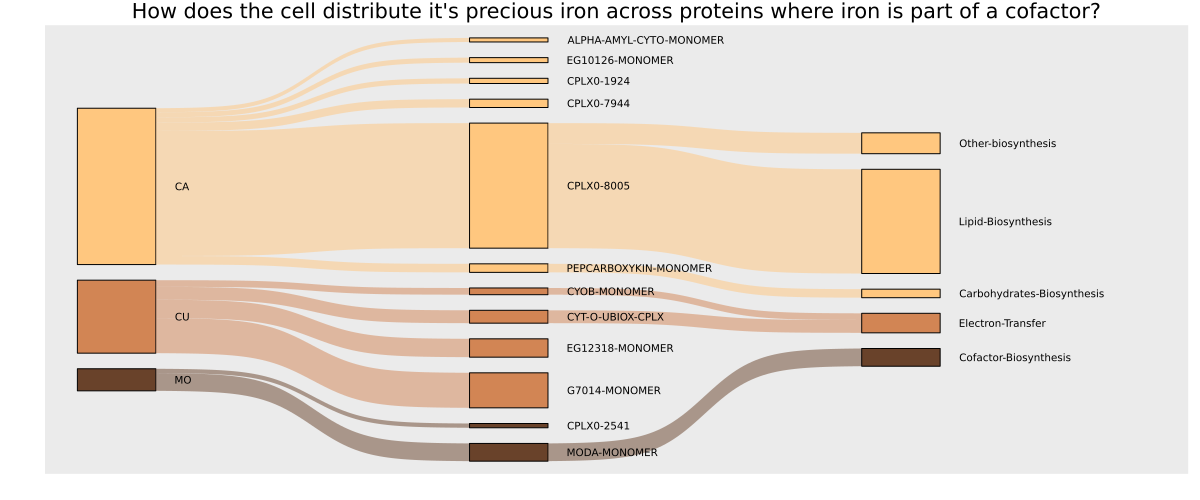

In [25]:
sankey(src, dst, weights, 
        compact = true,
        node_labels = node_labels,
        node_colors = cgrad(:copper, maximum(colors)+1, categorical = true, rev=true)[colors],
        edge_color = :src,
        size=(1200, 500),
        label_position = :right,
        label_size = 7,
        force_order = ordering_elements,
        title="How does the cell distribute it's precious iron across proteins where iron is part of a cofactor?"
)

# savefig("iron_cofactor_plot_biggg.png")

# original plots

In [10]:
# get top 10 iron
cur_element = "FE"
element_idx = element_names .== cur_element
top_included = 30

cofactors_with_element_idx = vec(E[:, element_idx] .!= 0)

complexes_by_this_element = vec(C_counts_elements[:, element_idx])
top_element_content_indices = sortperm(complexes_by_this_element, rev=true)[1:top_included]

top_complex_cofactor_map = (C_counts * P)[top_element_content_indices, cofactors_with_element_idx]


src = Vector{Int64}()
dst = Vector{Int64}()
weights = Vector{Int64}()

ordering_cofactors = Vector{Pair{Int64, Int64}}()

n_cplx = size(top_complex_cofactor_map)[1]
n_cofactor = size(top_complex_cofactor_map)[2]

selected_cofactor_names = cofactor_names[cofactors_with_element_idx]

node_labels = [cur_element; 
                selected_cofactor_names; 
                protein_names[top_element_content_indices];
                ["Remaining $c" for c ∈ selected_cofactor_names]]

colors = zeros(Int64, length(node_labels))

element_color = 1
other_color = 1+n_cofactor+1
cofactor_colors = collect(2:(n_cofactor+1))
cplx_colors = zeros(n_cplx)


n_cofactors_sum = vec(sum((C_counts * P), dims=1))[cofactors_with_element_idx]
n_cofactors_sum_elementwise = n_cofactors_sum .* E[cofactors_with_element_idx, element_idx]

remaining_cofactors = n_cofactors_sum - vec(sum(top_complex_cofactor_map, dims=1))

# element color
colors[1] = element_color
colors[2:(n_cofactor+1)] = cofactor_colors

for j in 1:n_cofactor
    push!(src, 1)
    push!(dst, 1+j)
    push!(weights, n_cofactors_sum_elementwise[j])
end

for j in 1:n_cofactor
    for i in 1:n_cplx
        if top_complex_cofactor_map[i,j] != 0
            push!(src, 1+j)
            push!(dst, 1+n_cofactor + i)
            push!(weights, top_complex_cofactor_map[i,j] * E[cofactors_with_element_idx, element_idx][j])    
            
            colors[1+n_cofactor+i] = cofactor_colors[j]
        end
    end
    
    # remaining
    push!(src, 1 + j)
    push!(dst, 1 + n_cofactor + n_cplx + j)
    push!(weights, remaining_cofactors[j] * E[cofactors_with_element_idx, element_idx][j])
    
end

# remaining colors
colors[colors .== 0] .= other_color


# create sorting

sort_cofactors = sortperm(vec(n_cofactors_sum_elementwise), rev=true)


for i in 1:(n_cofactor-1)
    
    
    push!(ordering_cofactors, 1+sort_cofactors[i]=>1+sort_cofactors[i+1])
end


already_sorted = Vector{Int64}()

for i in sort_cofactors
    name = node_labels[1+i]
    # println("currently sorting $name")
    # exclude last element since redundant
    sorted_column = sortperm(top_complex_cofactor_map[:, i], rev=true)
    nonzero = sum(top_complex_cofactor_map[sorted_column, i] .> 0)
    
    for j in 1:length(sorted_column[1:nonzero-1])
        
        
        cplx_name = node_labels[1+n_cofactor+sorted_column[j]]
        downstream = node_labels[1+n_cofactor+sorted_column[j+1]]
        
        count = top_complex_cofactor_map[sorted_column[j], i]
        
        # println("currently sorting $cplx_name with count $count")
        
        if !(sorted_column[j] in already_sorted || sorted_column[j+1] in already_sorted)
            
            # println("Connecting node $cplx_name with $downstream")
            
            push!(ordering_cofactors, 
                        1+n_cofactor+sorted_column[j] => 1+n_cofactor+sorted_column[j+1])


        end
    end
    
    append!(already_sorted, sorted_column[1:nonzero-1])
    
end

# create internal sorting of largest cofactor sizes



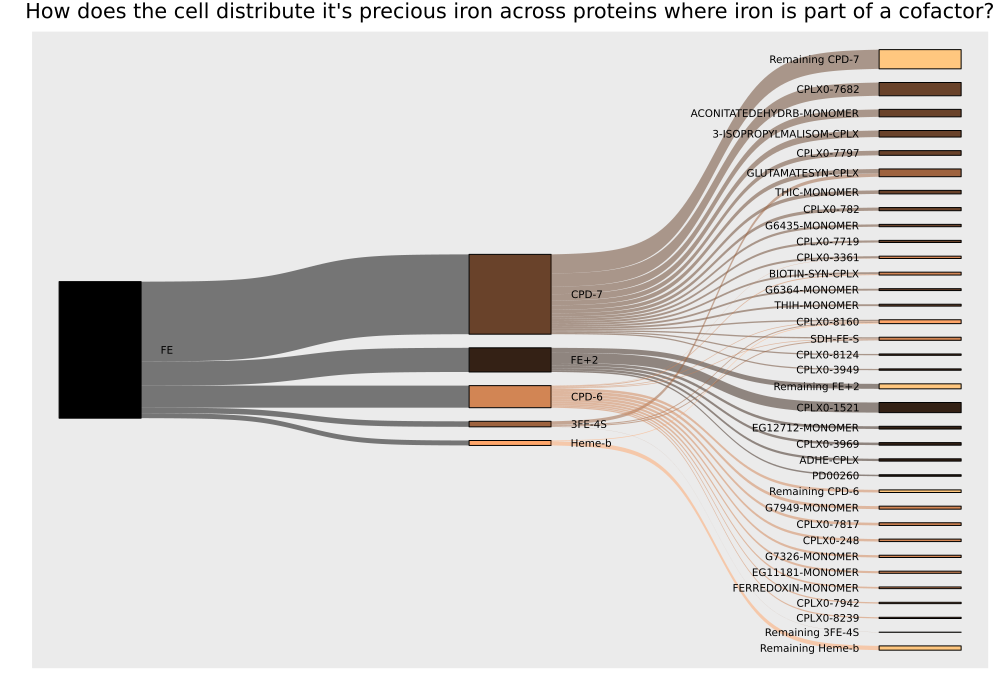

In [55]:
sankey(src, dst, weights, 
        compact = true,
        node_labels = node_labels,
        node_colors = cgrad(:copper, maximum(colors), categorical = true)[colors],
        edge_color = :src,
        size=(1000, 700),
        #label_position = :inside,
        label_size = 7,
        force_order = ordering_cofactors,
        title="How does the cell distribute it's precious iron across proteins where iron is part of a cofactor?"
)

# savefig("iron_cofactor_plot_biggg.png")

In [56]:
cgrad(:matter, length(node_labels), categorical = true)

# Recreate Sankey with categories

In [57]:
Counts = repeat(counts, 1, length(monomer_names))

C_norm = Array{Float64}(copy(C))

for i in 1:size(C)[2]
    C_norm[:, i] = C[:, i] / sum(C[:, i])
end

C_norm_counts = C_norm .* Counts

C_norm_counts_cats = C_norm_counts * W

5488×1164 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [58]:
sum(C_norm_counts_cats)

438483.16054451466

In [59]:
findfirst(isequal("EG10321-MONOMER"), protein_names)

1533

In [60]:
protein_names[sortperm(counts)]

5488-element Vector{String}:
 "ABC-23-CPLX"
 "ABC-52-CPLX"
 "ABC-55-CPLX"
 "ABC-56-CPLX"
 "ACETOACETYL-COA-TRANSFER-CPLX"
 "ACETOLACTSYNII-CPLX"
 "ALPHA-SUBUNIT-CPLX"
 "ATOA-CPLX"
 "ATOD-CPLX"
 "ATPASE-1-CPLX"
 "B2-CPLX"
 "BETAGALACTOSID-CPLX"
 "CITTRANS-CPLX"
 ⋮
 "EG10890-MONOMER"
 "EG10321-MONOMER"
 "EG10673-MONOMER"
 "EG12204-MONOMER"
 "EG10920-MONOMER"
 "CPLX0-8223"
 "EG11384-MONOMER"
 "EG11036-MONOMER"
 "PD00288"
 "EG10669-MONOMER"
 "EG50003-MONOMER"
 "EG10544-MONOMER"

In [61]:
# get top 10 iron
cur_element = "FE"
element_idx = element_names .== cur_element

cofactors_with_element_idx = vec(E[:, element_idx] .!= 0)

C_norm_element_counts = (C_norm .* complex_counts_by_this_element) * W * W2

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 5488 and 27440

In [70]:
# get top 10 iron
cur_element = "FE"
element_idx = element_names .== cur_element
top_included = 50

cofactors_with_element_idx = vec(E[:, element_idx] .!= 0)

complexes_by_this_element = vec(C_counts_elements[:, element_idx])
top_element_content_indices = sortperm(complexes_by_this_element, rev=true)[1:top_included]


top_complex_cofactor_map = (C_counts * P)[top_element_content_indices, cofactors_with_element_idx]

# for last layer
complex_counts_by_this_element = vec(C_counts_elements[:, element_idx])
C_norm_element_counts = (C_norm .* complex_counts_by_this_element) * W
relevant_classes = vec(sum(C_norm_element_counts[top_element_content_indices, :], dims=1) .!= 0)
top_cplx_class_counts = C_norm_element_counts[top_element_content_indices,relevant_classes]

src = Vector{Int64}()
dst = Vector{Int64}()
weights = Vector{Int64}()

ordering_cofactors = Vector{Pair{Int64, Int64}}()

n_cplx = size(top_complex_cofactor_map)[1]
n_cofactor = size(top_complex_cofactor_map)[2]
n_class = size(top_cplx_class_counts)[2]

selected_cofactor_names = cofactor_names[cofactors_with_element_idx]

node_labels = [cur_element; 
                selected_cofactor_names; 
                protein_names[top_element_content_indices];
                pathway_names[relevant_classes];
                ["Remaining $c" for c ∈ selected_cofactor_names]]

colors = zeros(Int64, length(node_labels))

element_color = 1
other_color = 1+n_cofactor+1
cofactor_colors = collect(2:(n_cofactor+1))
cplx_colors = zeros(n_cplx)


n_cofactors_sum = vec(sum((C_counts * P), dims=1))[cofactors_with_element_idx]
n_cofactors_sum_elementwise = n_cofactors_sum .* E[cofactors_with_element_idx, element_idx]

remaining_cofactors = n_cofactors_sum - vec(sum(top_complex_cofactor_map, dims=1))

# element color
colors[1] = element_color
colors[2:(n_cofactor+1)] = cofactor_colors

for j in 1:n_cofactor
    push!(src, 1)
    push!(dst, 1+j)
    push!(weights, n_cofactors_sum_elementwise[j])
end

for j in 1:n_cofactor
    for i in 1:n_cplx
        if top_complex_cofactor_map[i,j] != 0
            push!(src, 1+j)
            push!(dst, 1+n_cofactor + i)
            push!(weights, top_complex_cofactor_map[i,j] * E[cofactors_with_element_idx, element_idx][j])    
            
            colors[1+n_cofactor+i] = cofactor_colors[j]
        end
    end
    
    # remaining
    push!(src, 1 + j)
    push!(dst, 1 + n_cofactor + n_class + n_cplx + j)
    push!(weights, remaining_cofactors[j] * E[cofactors_with_element_idx, element_idx][j])
    
end

for j in 1:n_cplx
    for i in 1:n_class
        if top_cplx_class_counts[j, i] != 0
            push!(src, 1+n_cofactor+j)
            push!(dst, 1+n_cofactor + n_cplx + i)
            push!(weights, Int64(round((top_cplx_class_counts[j, i])))  )    
            
            # colors[1+n_cofactor+i] = cofactor_colors[j]
        end        
    end
    
end


# remaining colors
colors[colors .== 0] .= other_color


# create sorting

sort_cofactors = sortperm(vec(n_cofactors_sum_elementwise), rev=true)


for i in 1:(n_cofactor-1)
    
    
    push!(ordering_cofactors, 1+sort_cofactors[i]=>1+sort_cofactors[i+1])
end


already_sorted = Vector{Int64}()

for i in sort_cofactors
    name = node_labels[1+i]
    # println("currently sorting $name")
    # exclude last element since redundant
    sorted_column = sortperm(top_complex_cofactor_map[:, i], rev=true)
    nonzero = sum(top_complex_cofactor_map[sorted_column, i] .> 0)
    
    for j in 1:length(sorted_column[1:nonzero-1])
        
        
        cplx_name = node_labels[1+n_cofactor+sorted_column[j]]
        downstream = node_labels[1+n_cofactor+sorted_column[j+1]]
        
        count = top_complex_cofactor_map[sorted_column[j], i]
        
        # println("currently sorting $cplx_name with count $count")
        
        if !(sorted_column[j] in already_sorted || sorted_column[j+1] in already_sorted)
            
            # println("Connecting node $cplx_name with $downstream")
            
            push!(ordering_cofactors, 
                        1+n_cofactor+sorted_column[j] => 1+n_cofactor+sorted_column[j+1])


        end
    end
    
    append!(already_sorted, sorted_column[1:nonzero-1])
    
end

# create internal sorting of largest cofactor sizes



In [71]:
sankey(src, dst, weights, 
        compact = true,
        node_labels = node_labels,
        node_colors = cgrad(:copper, maximum(colors), categorical = true)[colors],
        edge_color = :src,
        size=(1300, 1200),
        label_position = :right,
        label_size = 7,
        force_order = ordering_cofactors,
        title="How does the cell distribute its precious iron across proteins where iron is part of a cofactor?"
)

# savefig("iron_cofactor_plot_biggg.png")

# How many ions of interest seem to be bound in the cell?

In [27]:
element_names

19-element Vector{String}:
 "MO"
 "R"
 "ZN"
 "MN"
 "MG"
 "P"
 "N"
 "NA"
 "K"
 "CU"
 "S"
 "CA"
 "NI"
 "FE"
 "O"
 "H"
 "CO"
 "SE"
 "C"

In [18]:
cur_elements = ["FE", "MN", "ZN", "NI", "CA", "CU", "SE"]
element_idx = [element in cur_elements for element in element_names]

display_element_names = element_names[element_idx]

element_counts = vec(sum(C_counts_elements[:, element_idx], dims=1))

7-element Vector{Int64}:
 149239
  40243
   4872
  10028
   8625
 219263
      0

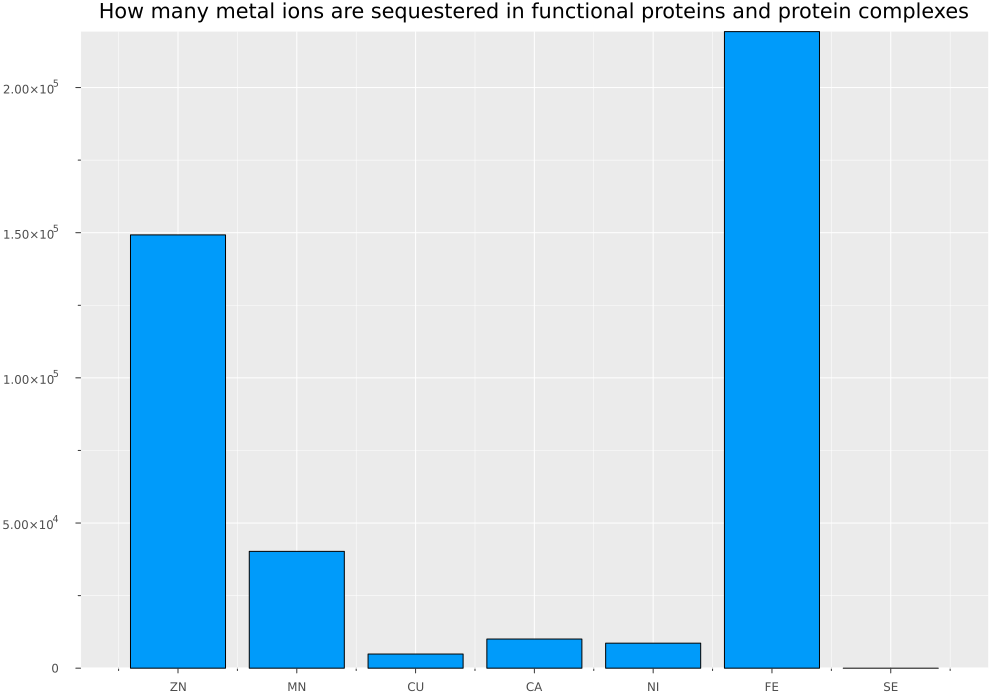

In [19]:
plot(bar(display_element_names, element_counts), legend = false, size=[1000,700],
    title="How many metal ions are sequestered in functional proteins and protein complexes")

# For rarer metals, where do they bind?

In [72]:
dst

141-element Vector{Int64}:
  2
  3
  4
  5
  6
  8
 19
 21
 26
 32
 51
 52
 54
  ⋮
 80
 81
 60
 80
 81
 58
 63
 64
 65
 67
 69
 70

In [73]:
node_labels

91-element Vector{String}:
 "FE"
 "FE+2"
 "CPD-7"
 "3FE-4S"
 "CPD-6"
 "Heme-b"
 "CPLX0-7682"
 "CPLX0-1521"
 "GLUTAMATESYN-CPLX"
 "ACONITATEDEHYDRB-MONOMER"
 "3-ISOPROPYLMALISOM-CPLX"
 "CPLX0-7797"
 "CPLX0-8160"
 ⋮
 "PWY-7220"
 "PWY-7222"
 "PWY-6153"
 "NONMEVIPP-PWY"
 "GLUTSYN-PWY"
 "PWY0-1021"
 "LEUSYN-PWY"
 "Remaining FE+2"
 "Remaining CPD-7"
 "Remaining 3FE-4S"
 "Remaining CPD-6"
 "Remaining Heme-b"

In [74]:
C_norm_element_counts

5488×1164 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

5488-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0

In [ ]:
complex_counts_by_this_element = vec(C_counts_elements[:, element_idx])
C_norm_element_counts = (C_norm .* complex_counts_by_this_element) * W * W2
relevant_classes = vec(sum(C_norm_element_counts[top_element_content_indices, :], dims=1) .!= 0)
top_cplx_class_counts = C_norm_element_counts[top_element_content_indices,relevant_classes]

1×1164 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

# misc


In [29]:
protein_names[capped_complex_idx]

30-element Vector{String}:
 "SUPEROX-DISMUTMN-CPLX"
 "HOMOCYSMET-MONOMER"
 "FRUCBISALD-CLASSII"
 "ASPCARBTRANS-CPLX"
 "CRR-MONOMER"
 "CPLX0-8005"
 "CPLX0-7521"
 "FOLE-CPLX"
 "CARBPSYN-CPLX"
 "TAGAALDOL2-MONOMER"
 "DIHYDROOROT-CPLX"
 "APORNAP-CPLX"
 "EG10230-MONOMER"
 ⋮
 "PD00260"
 "BIOTIN-CARBOXYL-CPLX"
 "GLURS-MONOMER"
 "EG10889-MONOMER"
 "CPLX0-8156"
 "ILES-MONOMER"
 "THIC-MONOMER"
 "ALAS-CPLX"
 "CPLX-157"
 "METG-CPLX"
 "G6475-MONOMER"
 "CPLX0-7945"

In [60]:
W[4166, 578]

0.9999999999

In [63]:
C_norm[1023, 4166] * W[4166, 578]

0.6666666666

In [59]:
C_W_norm_counts_cats[1023,578]

6648.666666001799

In [39]:
findfirst(isequal("REACTIVE-OXYGEN-SPECIES-DEGRADATION"), pathway_names)

577

In [51]:
findfirst(isequal("DETOX1-PWY"), pathway_names)

578

In [82]:
findfirst(isequal("CARBPSYN-CPLX"), protein_names)

139

In [85]:
sum(C_norm[139,:])

1.3333333333333333

In [ ]:
C[:, i]

In [ ]:
C_norm[:, i] = C[:, i] / sum(C[:, i])